In [2]:
import pandas as pd
import statsmodels.api as sm
from scipy import interpolate
from pandas import Series, DataFrame, Panel
from string import ascii_lowercase as letters
from scipy.stats import chisqprob
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
from scipy.stats import wrapcauchy
import matplotlib.pyplot as plt
%matplotlib inline
%precision 4
plt.style.use('classic')
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from functools import partial
np.random.seed(1234)

/srv/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
def rw2(n):# this gives samples from weibull(5,2)
    x=np.zeros(n)
    y=np.zeros(n)
    theta=[0]*n
    theta[0]=wrapcauchy.rvs(c,loc=0,size=1)
    if theta[0]>2*math.pi:
            theta[0] = theta[0] - 2* math.pi
    if theta[0]<0:
            theta[0] = theta[0] + 2* math.pi
    for i in range(1,n):
        r=random.weibullvariate(alpha,beta)
        theta[i]=wrapcauchy.rvs(c,loc=theta[i-1],size=1)# c is the shape parameter
        if theta[i]>2*math.pi:
            theta[i] =theta[i] - 2* math.pi
        if theta[i]<0:
            theta[i] = theta[i] + 2* math.pi
        x[i]=x[i-1]+r*math.cos(theta[i])
        y[i]=y[i-1]+r*math.sin(theta[i])
    return(x,y)   
    
n=10000 #sample size
alpha=2 #scale
beta=5 #shape
c=0.9# shape parameter for Wrapped Cauchy distribution, it needs to be between 0 and 1
data = rw2(n)
x=data[0]
y=data[1]
t=range(0,n)

In [4]:
# average distance
def rw2_distance(n):# this gives samples from weibull(5,2)
    x=np.zeros(n)
    y=np.zeros(n)
    theta=[0]*n
    distance=[0]*n
    theta[0]=wrapcauchy.rvs(c,loc=0,size=1)
    if theta[0]>2*math.pi:
            theta[0] = theta[0] - 2* math.pi
    if theta[0]<0:
            theta[0] = theta[0] + 2* math.pi
    for i in range(1,n):
        r=random.weibullvariate(alpha,beta)
        theta[i]=wrapcauchy.rvs(c,loc=theta[i-1],size=1)# c is the shape parameter
        if theta[i]>2*math.pi:
            theta[i] =theta[i] - 2* math.pi
        if theta[i]<0:
            theta[i] = theta[i] + 2* math.pi
        x[i]=x[i-1]+r*math.cos(theta[i])
        y[i]=y[i-1]+r*math.sin(theta[i])
        distance[i]=(x[i]**2+y[i]**2)**0.5
    return distance 
    
n=10000 #sample size
alpha=2 #scale
beta=5 #shape
c=0.9# shape parameter for Wrapped Cauchy distribution, it needs to be between 0 and 1
data_distance = rw2_distance(n)
t=range(0,n)
#data_distance

In [5]:
number_of_simulations=100# this is the number of rows or row vectors
n=10000# number of columns or number of elements in that row vector
average_distances=np.zeros((number_of_simulations,n))
for i in range(number_of_simulations):
    average_distances[i]=rw2_distance(n)
#ask here if it's correct: average distance or just distance

In [6]:
rw2_distance(10)


[0, 2.0132, 3.9952, 5.8358, 7.7302, 6.6107, 6.0205, 6.6759, 7.6129, 7.5457]

In [7]:
matrix=np.zeros((2,5))# 2 rows 5 columns
matrix[1]=range(0,5)
matrix[0]=range(5,10)
print(matrix)
print(matrix.mean(axis=0))

[[ 5.  6.  7.  8.  9.]
 [ 0.  1.  2.  3.  4.]]
[ 2.5  3.5  4.5  5.5  6.5]


In [8]:
# the mean average distance after 1 step, 2 steps, etc...

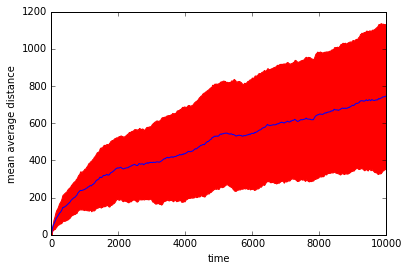

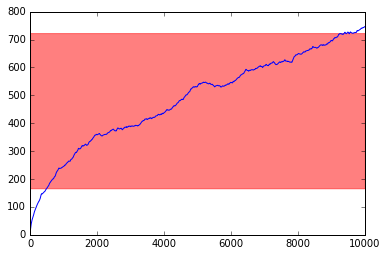

In [9]:
u=average_distances.mean(axis=0)
error=average_distances.var(axis=0)**0.5
plt.plot(t,u)
plt.fill_between(t, u-error, u+error,color='red')
#plt.plot(t,y-error)
#plt.plot(t,y+error)
plt.xlabel('time')
plt.ylabel('mean average distance')
plt.show()
ninety_fifth_percentile=np.percentile(u,95)
fifth_percentile=np.percentile(u,5)
plt.plot(t,u)
#plt.fill_between(t,ninety_fifth_percentile,alpha=0.5,color='red')
plt.fill_between(t,fifth_percentile,ninety_fifth_percentile,color='red',alpha=0.5)
plt.show()

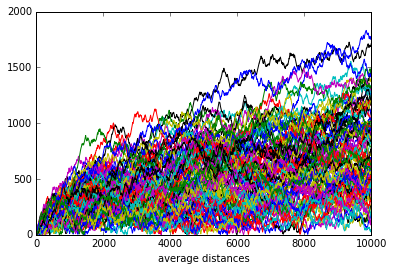

In [10]:
plt.plot(average_distances.T)
plt.xlabel('time')
plt.xlabel('average distances')
plt.show()

In [12]:
# my code pretty much starts here
time_step=0.1
t_new=np.arange(0,n-1,time_step)
f=interpolate.interp1d(t,x,kind='cubic')#,fill_value="extrapolate")
g=interpolate.interp1d(t,y,kind='cubic')#,fill_value="extrapolate") don't do this

In [13]:
x_new=f(t_new)
y_new=g(t_new)

In [14]:
#get the distances now and the angles
r=np.zeros(len(x_new)-1)# r the step-lengths
theta=np.zeros(len(x_new)-1)# theta the angle
new_data=np.zeros(len(x_new)-1)
for i in range(0,len(x_new)-1):
    r[i]=np.sqrt((x_new[i+1]-x_new[i])**2 + (y_new[i+1]-y_new[i])**2)
    theta[i]=math.atan2(y_new[i+1]-y_new[i], x_new[i+1]-x_new[i])
for i in range(0,len(x_new)-2):
    new_data[i]=theta[i+1]-theta[i]# save the difference in the heading
    if new_data[i]<0:
        new_data[i]=new_data[i]+2*math.pi    
data=r# save the step-lengths,have the same name as before in the MCMC sampler for the step-lengths
#new_data is the data that we introduce in the heading MCMC sampler
print(len(data))    
print(len(theta))
print(len(new_data))
new_data# it has a zero at the end
new_data=new_data[:-1]
#new_data without zero.
data=data[:-1]# change the step-lengths data as well
print(len(data))
print(len(new_data))# make sure they have the same lenghts


99989
99989
99989
99988
99988


In [15]:
# Now put them into the MCMC sampler, the second model is to be considered
import scipy.stats 
from scipy.stats import dweibull
def log_likelihood(x,a,b):# a is shape, b is scale
     return sum(dweibull.logpdf(x,scale=b,c=a))
def log_wclikelihood(x,a,b):
     return sum(wrapcauchy.logpdf(x,c=a,loc=b))# c is the shape parameter

In [16]:
#MCMC sampler for the heading
# initial guess for theta(a) as array,these are shape(c) 
guess = 0.9
# Prepare storing MCMC chain as array of arrays.
A1 = [guess]
# define stepsize of MCMC.
stepsize = 0.00025 # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_wclikelihood(new_data,old_theta,0)#calculate the first log likelihood
# Metropolis-Hastings with 20,000 iterations.
for p in range(20000):
    new_theta = old_theta + stats.norm(0, stepsize).rvs() 
    #add the restraints on new_theta
    if new_theta<0 or new_theta>1: 
        continue
    new_loglik = log_wclikelihood(new_data,new_theta,0)
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A1.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A1.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
        else:
            A1.append(old_theta)
print("Acceptance rate = "+str(accepted/10000.0))

Acceptance rate = 0.3712


0.990239549722
0.992395591034


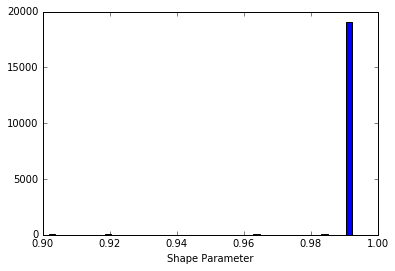

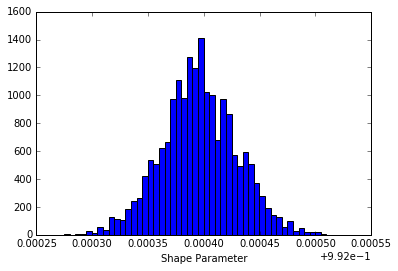

In [17]:
print(np.mean(A1))
print(np.mean(A1[1000:]))# burn in 1000
plt.hist(A1,bins=50)
plt.xlabel("Shape Parameter")
plt.show()
B1=np.array(A1[1000:])
plt.hist(B1,bins=50)
plt.xlabel("Shape Parameter")
plt.show()


In [18]:
#MCMC sampler for the step-lengths
import scipy.stats as stats
import numpy as np
# initial guess for theta(a and b) as array.
guess = [5.0,2.0]
# Prepare storing MCMC chain as array of arrays.
A2 = [guess]
# define stepsize of MCMC.
stepsizes = [0.0027,0.0027]  # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_likelihood(data,old_theta[0],old_theta[1])#calculate the first log likelihood
# Metropolis-Hastings with 25,000 iterations.
for p in range(25000):
    # Suggest new candidate from Gaussian proposal distribution.
    new_theta = old_theta + stats.norm(0, stepsizes).rvs() 
    #add the restraints on new_theta
    if new_theta[0]<0 or new_theta[1]<0: 
        continue
    new_loglik = log_likelihood(data,new_theta[0],new_theta[1])
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A2.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A2.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
        else:
            A2.append(old_theta)
print("Acceptance rate = "+str(accepted/10000.0))

Acceptance rate = 0.3872


25001
1.87737636832
0.135554294815


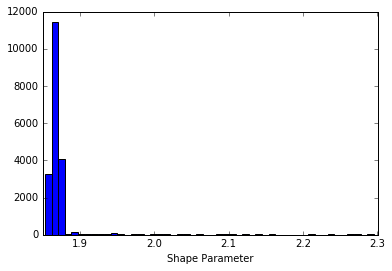

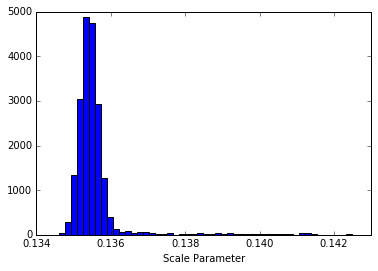

In [19]:
print(len(A2))
B2=np.array(A2[5000:])#burn-in 5000
shape_mean=np.mean(B2[:,0])
scale_mean=np.mean(B2[:,1])
print(shape_mean)
print(scale_mean)
plt.hist(B2[:,0],bins=50)
plt.xlabel("Shape Parameter")
plt.show()
plt.hist(B2[:,1],bins=50)
plt.xlabel("Scale Parameter")
plt.show()

In [20]:
# now changing the parameters and n with the ones that I got
def rw2_change(n_change):# this gives samples from weibull(5,2)
    x_change=np.zeros(n_change)
    y_change=np.zeros(n_change)
    theta=[0]*n_change
    distance=[0]*n_change
    theta[0]=wrapcauchy.rvs(c_change,loc=0,size=1)
    if theta[0]>2*math.pi:
            theta[0] = theta[0] - 2* math.pi
    if theta[0]<0:
            theta[0] = theta[0] + 2* math.pi
    for i in range(1,n_change):
        r=random.weibullvariate(alpha_change,beta_change)
        theta[i]=wrapcauchy.rvs(c_change,loc=theta[i-1],size=1)# c is the shape parameter
        if theta[i]>2*math.pi:
            theta[i] =theta[i] - 2* math.pi
        if theta[i]<0:
            theta[i] = theta[i] + 2* math.pi
        x_change[i]=x_change[i-1]+r*math.cos(theta[i])
        y_change[i]=y_change[i-1]+r*math.sin(theta[i])
        distance[i]=(x_change[i]**2+y_change[i]**2)**0.5
    return distance 
    
n_change=len(new_data) #int(input("how many steps?"))
alpha_change=scale_mean #int(input("what's the scale?"))
beta_change=shape_mean #int(input("what's the shape?"))
c_change=np.mean(A1)# float(input("What's the shape parameter for the wrapped Cauchy?"))# this needs to be between 0 and 1


In [21]:
rw2_change(2)

[0, 0.0567]

In [ ]:
number_of_simulations=100
average_distances_change=np.zeros((number_of_simulations,n_change))
for i in range(number_of_simulations):
    average_distances_change[i]=rw2_change(n_change)

In [ ]:
print(len(t_new))
print(len(average_distances_change.mean(axis=0)))

In [ ]:
lower_end_vector_original=[np.percentile(average_distances.mean(axis=0),2.5)]*len(t)
upper_end_vector_original=[np.percentile(average_distances.mean(axis=0),97.5)]*len(t)
lower_end_vector_change=[np.percentile(average_distances_change.mean(axis=0),2.5)]*len(t_new[:-2])
upper_end_vector_change=[np.percentile(average_distances_change.mean(axis=0),97.5)]*len(t_new[:-2])
ninetyfive_percentile_original=[np.percentile(average_distances.mean(axis=0),95)]*len(t)
ninetyfive_percentile_change=[np.percentile(average_distances_change.mean(axis=0),95)]*len(t_new[:-2])
plt.plot(t_new[:-2],average_distances_change.mean(axis=0))#important
plt.plot(t,lower_end_vector_original,color='red')
plt.plot(t,upper_end_vector_original,color='red')
plt.plot(t_new[:-2],lower_end_vector_change,color='purple')
plt.plot(t_new[:-2],upper_end_vector_change,color='purple')
#plt.plot(t_new[:-2],ninetyfive_percentile_change,color='orange')
#plt.plot(t,ninetyfive_percentile_original,color='orange')
plt.ylabel('average distance from the origin')
plt.xlabel('time ')
plt.plot(t,average_distances.mean(axis=0))#important
#not the most important box

In [ ]:
u=average_distances.mean(axis=0)
error=average_distances.var(axis=0)**0.5
y_change=average_distances_change.mean(axis=0)
error_change=average_distances_change.var(axis=0)**0.5
plt.plot(t,u,color='orange')
plt.fill_between(t, u-error, u+error,color='green',alpha=0.7)
plt.plot(t_new[:-2],average_distances_change.mean(axis=0),color='red')
plt.fill_between(t_new[:-2], y_change-error_change, y_change+error_change,color='blue',alpha=0.2)
plt.xlabel('time')
plt.ylabel('mean average distance')
plt.show()
# the portion in the middle is the intersection of the two shaded areas
# the boundaries are: for the green one : the upper line together with the last line of the intersection line
# for the blue one: the lowest line is the lower boundary and the upper line of the intersection 
#is the upper boundary
#the most important box

In [ ]:
u=average_distances.mean(axis=0)
error=average_distances.var(axis=0)**0.5
y_change=average_distances_change.mean(axis=0)
error_change=average_distances_change.var(axis=0)**0.5
plt.plot(t,u,color='orange')
plt.fill_between(t, u-error, u+error,color='green',alpha=0.7)
plt.show()
plt.plot(t_new[:-2],average_distances_change.mean(axis=0),color='red')
plt.fill_between(t_new[:-2], y_change-error_change, y_change+error_change,color='blue',alpha=0.2)
#plt.plot(t,y-error)
#plt.plot(t,y+error)
plt.xlabel('time')
plt.ylabel('mean average distance')
plt.show()
#the two lines done separately

In [ ]:
print(len(average_distances_change.mean(axis=0)))
print(len(t_new))
# it still goes to 10,000 but it has more points

In [ ]:
plt.plot(t_new[:-2],average_distances_change.T)
plt.ylabel('average distance')
plt.xlabel('time')
plt.show()
plt.plot(average_distances.T)
plt.xlabel('time')
plt.ylabel('average distance')
plt.show()

In [ ]:
# calculating the distance from the origin in the new data
# this is just for one sample
distance_origin_new_data=np.zeros(len(x_new))
distance_origin_new_data=(x_new**2+y_new**2)**0.5

In [ ]:
distance_origin_new_data

In [ ]:
#I need to do the mean average distance across the number of simulations

In [ ]:
number_new_simulations=100
average_new_data_distances=np.zeros((number_new_simulations,len(x_new)))

In [ ]:
for i in range(number_new_simulations):
                               data=rw2(n)
                               x=data[0]
                               y=data[1]
                               t_new=np.arange(0,n-1,time_step)
                               f=interpolate.interp1d(t,x,kind='cubic')
                               g=interpolate.interp1d(t,y,kind='cubic')
                               x_new=f(t_new)
                               y_new=g(t_new)
                               distance_origin_new_data=np.zeros(len(x_new))
                               distance_origin_new_data=(x_new**2+y_new**2)**0.5# this becomes the first row and so on of the matrix
                               average_new_data_distances[i,]=distance_origin_new_data

In [ ]:
# the mean average distance after 1 step, 2 steps, etc...
y_new_data=average_new_data_distances.mean(axis=0)
error_new_data=average_new_data_distances.var(axis=0)**0.5
plt.plot(t_new,y_new_data)
plt.fill_between(t_new, y_new_data-error_new_data, y_new_data+error_new_data,color='red')
plt.xlabel('time')
plt.ylabel('mean average distance')
plt.show()
#ninety_fifth_percentile=np.percentile(y_new_data,95)
#fifth_percentile=np.percentile(y_new_data,5)
#plt.plot(t,y)
#plt.fill_between(t,ninety_fifth_percentile,alpha=0.5,color='red')
#plt.fill_between(t,fifth_percentile,ninety_fifth_percentile,color='red',alpha=0.5)
#plt.show()

In [ ]:
plt.plot(average_new_data_distances.T)
plt.xlabel('time')
plt.xlabel('average distances')
plt.show()

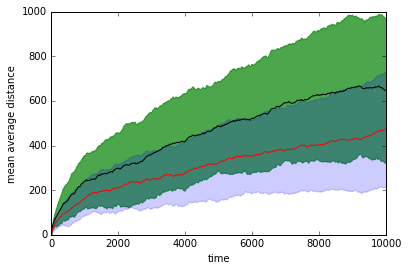

In [37]:
# the line from the inference and the line from the new data
y_new_data=average_new_data_distances.mean(axis=0)
error_new_data=average_new_data_distances.var(axis=0)**0.5
plt.plot(t_new,y_new_data,color='black')
plt.fill_between(t_new, y_new_data-error_new_data, y_new_data+error_new_data,color='green',alpha=0.7)
y_change=average_distances_change.mean(axis=0)
error_change=average_distances_change.var(axis=0)**0.5
plt.plot(t_new[:-2],average_distances_change.mean(axis=0),color='red')
plt.fill_between(t_new[:-2], y_change-error_change, y_change+error_change,color='blue',alpha=0.2)
plt.xlabel('time')
plt.ylabel('mean average distance')
plt.show()
# the portion in the middle is the intersection of the two shaded areas
# the boundaries are: for the green one : the upper line together with the last line of the intersection line
# for the blue one: the lowest line is the lower boundary and the upper line of the intersection 
#is the upper boundary
#the most important box

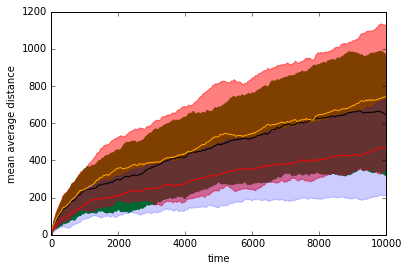

In [38]:
# the three lines all together
u=average_distances.mean(axis=0)
error=average_distances.var(axis=0)**0.5
y_new_data=average_new_data_distances.mean(axis=0)
error_new_data=average_new_data_distances.var(axis=0)**0.5
y_change=average_distances_change.mean(axis=0)
error_change=average_distances_change.var(axis=0)**0.5
plt.plot(t_new,y_new_data,color='black')
plt.fill_between(t_new, y_new_data-error_new_data, y_new_data+error_new_data,color='green',alpha=1)
plt.plot(t,u,color='orange')
plt.fill_between(t, u-error, u+error,color='red',alpha=0.5)
plt.plot(t_new[:-2],average_distances_change.mean(axis=0),color='red')
plt.fill_between(t_new[:-2], y_change-error_change, y_change+error_change,color='blue',alpha=0.2)
plt.xlabel('time')
plt.ylabel('mean average distance')
plt.show()

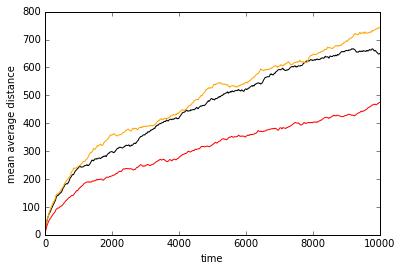

In [39]:
# the three lines all together without shaded areas
u=average_distances.mean(axis=0)
error=average_distances.var(axis=0)**0.5
y_new_data=average_new_data_distances.mean(axis=0)
error_new_data=average_new_data_distances.var(axis=0)**0.5
y_change=average_distances_change.mean(axis=0)
error_change=average_distances_change.var(axis=0)**0.5
plt.plot(t_new,y_new_data,color='black')
#plt.fill_between(t_new, y_new_data-error_new_data, y_new_data+error_new_data,color='green',alpha=1)
plt.plot(t,u,color='orange')
#plt.fill_between(t, y-error, y+error,color='red',alpha=0.5)
plt.plot(t_new[:-2],average_distances_change.mean(axis=0),color='red')
#plt.fill_between(t_new[:-2], y_change-error_change, y_change+error_change,color='blue',alpha=0.2)
plt.xlabel('time')
plt.ylabel('mean average distance')
plt.show()

In [40]:
#time_step=0.2
# my code pretty much starts here
time_step=0.2
t_new=np.arange(0,n-1,time_step)
f=interpolate.interp1d(t,x,kind='cubic')#,fill_value="extrapolate")
g=interpolate.interp1d(t,y,kind='cubic')#,fill_value="extrapolate") don't do this

In [41]:
x_new=f(t_new)
y_new=g(t_new)

In [42]:
#get the distances now and the angles
r=np.zeros(len(x_new)-1)# r the step-lengths
theta=np.zeros(len(x_new)-1)# theta the angle
new_data=np.zeros(len(x_new)-1)
for i in range(0,len(x_new)-1):
    r[i]=np.sqrt((x_new[i+1]-x_new[i])**2 + (y_new[i+1]-y_new[i])**2)
    theta[i]=math.atan2(y_new[i+1]-y_new[i], x_new[i+1]-x_new[i])
for i in range(0,len(x_new)-2):
    new_data[i]=theta[i+1]-theta[i]# save the difference in the heading
    if new_data[i]<0:
        new_data[i]=new_data[i]+2*math.pi    
data=r# save the step-lengths,have the same name as before in the MCMC sampler for the step-lengths
#new_data is the data that we introduce in the heading MCMC sampler
print(len(data))    
print(len(theta))
print(len(new_data))
new_data# it has a zero at the end
new_data=new_data[:-1]
#new_data without zero.
data=data[:-1]# change the step-lengths data as well
print(len(data))
print(len(new_data))# make sure they have the same lenghts

49994
49994
49994
49993
49993


In [43]:
#MCMC sampler for the heading
# initial guess for theta(a) as array,these are shape(c) 
guess = 0.9
# Prepare storing MCMC chain as array of arrays.
A1 = [guess]
# define stepsize of MCMC.
stepsize = 0.00065 # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_wclikelihood(new_data,old_theta,0)#calculate the first log likelihood
# Metropolis-Hastings with 20,000 iterations.
for p in range(20000):
    new_theta = old_theta + stats.norm(0, stepsize).rvs() 
    #add the restraints on new_theta
    if new_theta<0 or new_theta>1: 
        continue
    new_loglik = log_wclikelihood(new_data,new_theta,0)
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A1.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A1.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
        else:
            A1.append(old_theta)
print("Acceptance rate = "+str(accepted/10000.0))

Acceptance rate = 0.3814


0.98392688376
0.984670435736


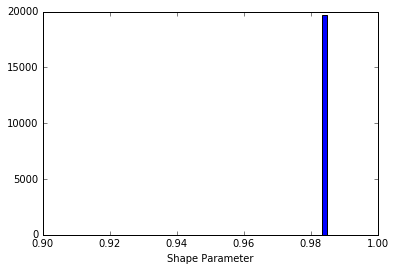

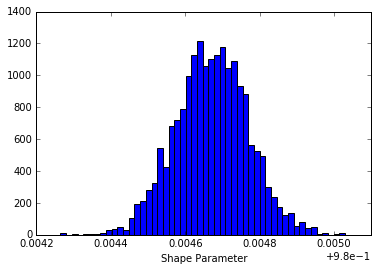

In [44]:
print(np.mean(A1))
print(np.mean(A1[1000:]))# burn in 1000
plt.hist(A1,bins=50)
plt.xlabel("Shape Parameter")
plt.show()
B1=np.array(A1[1000:])
plt.hist(B1,bins=50)
plt.xlabel("Shape Parameter")
plt.show()


In [45]:
#MCMC sampler for the step-lengths
import scipy.stats as stats
import numpy as np
# initial guess for theta(a and b) as array.
guess = [5.0,2.0]
# Prepare storing MCMC chain as array of arrays.
A2 = [guess]
# define stepsize of MCMC.
stepsizes = [0.005,0.005]  # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_likelihood(data,old_theta[0],old_theta[1])#calculate the first log likelihood
# Metropolis-Hastings with 25,000 iterations.
for p in range(25000):
    # Suggest new candidate from Gaussian proposal distribution.
    new_theta = old_theta + stats.norm(0, stepsizes).rvs() 
    #add the restraints on new_theta
    if new_theta[0]<0 or new_theta[1]<0: 
        continue
    new_loglik = log_likelihood(data,new_theta[0],new_theta[1])
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A2.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A2.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
        else:
            A2.append(old_theta)
print("Acceptance rate = "+str(accepted/10000.0))

Acceptance rate = 0.4149


25001
1.83370566706
0.267822762995


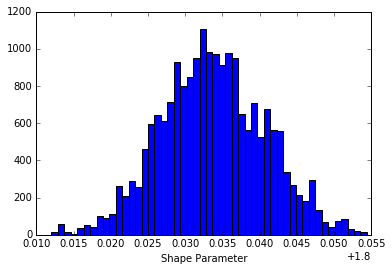

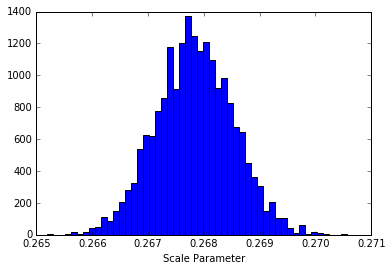

In [46]:
print(len(A2))
B2=np.array(A2[5000:])#burn-in 5000
shape_mean=np.mean(B2[:,0])
scale_mean=np.mean(B2[:,1])
print(shape_mean)
print(scale_mean)
plt.hist(B2[:,0],bins=50)
plt.xlabel("Shape Parameter")
plt.show()
plt.hist(B2[:,1],bins=50)
plt.xlabel("Scale Parameter")
plt.show()

In [47]:
# now changing the parameters and n with the ones that I got
def rw2_change(n_change):# this gives samples from weibull(5,2)
    x_change=np.zeros(n_change)
    y_change=np.zeros(n_change)
    theta=[0]*n_change
    distance=[0]*n_change
    theta[0]=wrapcauchy.rvs(c_change,loc=0,size=1)
    if theta[0]>2*math.pi:
            theta[0] = theta[0] - 2* math.pi
    if theta[0]<0:
            theta[0] = theta[0] + 2* math.pi
    for i in range(1,n_change):
        r=random.weibullvariate(alpha_change,beta_change)
        theta[i]=wrapcauchy.rvs(c_change,loc=theta[i-1],size=1)# c is the shape parameter
        if theta[i]>2*math.pi:
            theta[i] =theta[i] - 2* math.pi
        if theta[i]<0:
            theta[i] = theta[i] + 2* math.pi
        x_change[i]=x_change[i-1]+r*math.cos(theta[i])
        y_change[i]=y_change[i-1]+r*math.sin(theta[i])
        distance[i]=(x_change[i]**2+y_change[i]**2)**0.5
    return distance 
    
n_change=len(new_data) #int(input("how many steps?"))
alpha_change=scale_mean #int(input("what's the scale?"))
beta_change=shape_mean #int(input("what's the shape?"))
c_change=np.mean(A1)# float(input("What's the shape parameter for the wrapped Cauchy?"))# this needs to be between 0 and 1


In [48]:
number_of_simulations=100
average_distances_change=np.zeros((number_of_simulations,n_change))
for i in range(number_of_simulations):
    average_distances_change[i]=rw2_change(n_change)

In [49]:
print(len(t_new))
print(len(average_distances_change.mean(axis=0)))

49995
49993


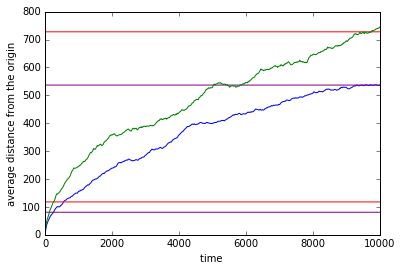

In [50]:
#plt.plot(t_new[:-2],average_distances_change.mean(axis=0))
#plt.plot(t,average_distances.mean(axis=0))
#plt.ylabel('average distance from the origin')
#plt.xlabel('time')
#the original code
lower_end_vector_original=[np.percentile(average_distances.mean(axis=0),2.5)]*len(t)
upper_end_vector_original=[np.percentile(average_distances.mean(axis=0),97.5)]*len(t)
lower_end_vector_change=[np.percentile(average_distances_change.mean(axis=0),2.5)]*len(t_new[:-2])
upper_end_vector_change=[np.percentile(average_distances_change.mean(axis=0),97.5)]*len(t_new[:-2])
ninetyfive_percentile_original=[np.percentile(average_distances.mean(axis=0),95)]*len(t)
ninetyfive_percentile_change=[np.percentile(average_distances_change.mean(axis=0),95)]*len(t_new[:-2])
plt.plot(t_new[:-2],average_distances_change.mean(axis=0))# important
plt.plot(t,lower_end_vector_original,color='red')
plt.plot(t,upper_end_vector_original,color='red')
plt.plot(t_new[:-2],lower_end_vector_change,color='purple')
plt.plot(t_new[:-2],upper_end_vector_change,color='purple')
#plt.plot(t_new[:-2],ninetyfive_percentile_change,color='orange')
#plt.plot(t,ninetyfive_percentile_original,color='orange')
plt.ylabel('average distance from the origin')
plt.xlabel('time ')
plt.plot(t,average_distances.mean(axis=0))#important

# blue is is the first one
# green is the second one

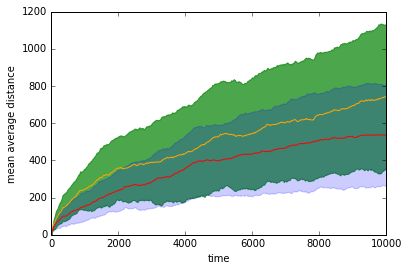

In [51]:
u=average_distances.mean(axis=0)
error=average_distances.var(axis=0)**0.5
y_change=average_distances_change.mean(axis=0)
error_change=average_distances_change.var(axis=0)**0.5
plt.plot(t,u,color='orange')
plt.fill_between(t, u-error, u+error,color='green',alpha=0.7)
plt.plot(t_new[:-2],average_distances_change.mean(axis=0),color='red')
plt.fill_between(t_new[:-2], y_change-error_change, y_change+error_change,color='blue',alpha=0.2)
#plt.plot(t,y-error)
#plt.plot(t,y+error)
plt.xlabel('time')
plt.ylabel('mean average distance')
plt.show()
# the portion in the middle is the intersection of the two shaded areas
# the boundaries are: for the green one : the upper line together with the last line of the intersection line
# for the blue one: the lowest line is the lower boundary and the upper line of the intersection 
#is the upper boundary

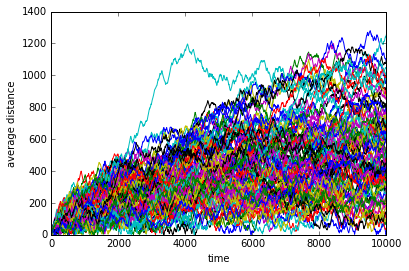

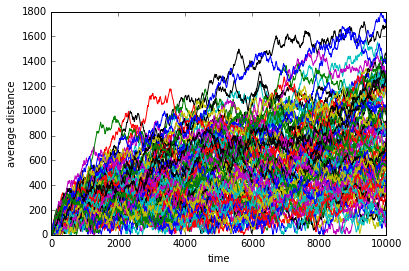

In [53]:
plt.plot(t_new[:-2],average_distances_change.T)
plt.ylabel('average distance')
plt.xlabel('time')
plt.show()
plt.plot(t,average_distances.T)
plt.ylabel('average distance')
plt.xlabel('time')
plt.show()

In [54]:
# calculating the distance from the origin in the new data
# this is just for one sample
distance_origin_new_data=np.zeros(len(x_new))
distance_origin_new_data=(x_new**2+y_new**2)**0.5

In [55]:
distance_origin_new_data

array([  0.0000e+00,   5.7221e-01,   1.1217e+00, ...,   7.6125e+02,
         7.6133e+02,   7.6142e+02])

In [56]:
#I need to do the mean average distance across the number of simulations

In [57]:
number_new_simulations=100
average_new_data_distances=np.zeros((number_new_simulations,len(x_new)))

In [58]:
for i in range(number_new_simulations):
                               data=rw2(n)
                               x=data[0]
                               y=data[1]
                               t_new=np.arange(0,n-1,time_step)
                               f=interpolate.interp1d(t,x,kind='cubic')
                               g=interpolate.interp1d(t,y,kind='cubic')
                               x_new=f(t_new)
                               y_new=g(t_new)
                               distance_origin_new_data=np.zeros(len(x_new))
                               distance_origin_new_data=(x_new**2+y_new**2)**0.5# this becomes the first row and so on of the matrix
                               average_new_data_distances[i,]=distance_origin_new_data

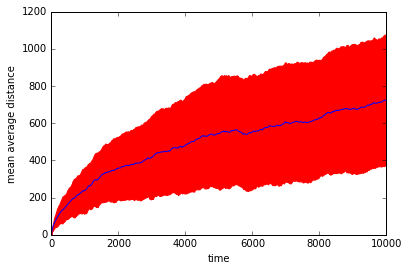

In [59]:
# the mean average distance after 1 step, 2 steps, etc...
y_new_data=average_new_data_distances.mean(axis=0)
error_new_data=average_new_data_distances.var(axis=0)**0.5
plt.plot(t_new,y_new_data)
plt.fill_between(t_new, y_new_data-error_new_data, y_new_data+error_new_data,color='red')
plt.xlabel('time')
plt.ylabel('mean average distance')
plt.show()
#ninety_fifth_percentile=np.percentile(y_new_data,95)
#fifth_percentile=np.percentile(y_new_data,5)
#plt.plot(t,y)
#plt.fill_between(t,ninety_fifth_percentile,alpha=0.5,color='red')
#plt.fill_between(t,fifth_percentile,ninety_fifth_percentile,color='red',alpha=0.5)
#plt.show()

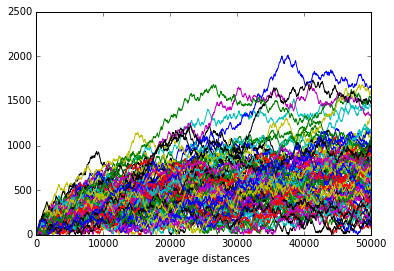

In [60]:
plt.plot(average_new_data_distances.T)
plt.xlabel('time')
plt.xlabel('average distances')
plt.show()

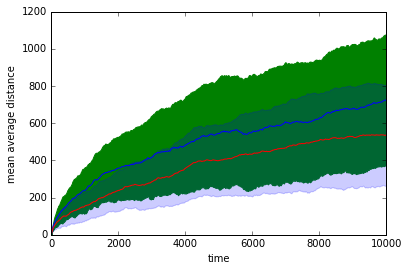

In [62]:
# the line from the inference and the line from the new data
y_new_data=average_new_data_distances.mean(axis=0)
error_new_data=average_new_data_distances.var(axis=0)**0.5
plt.plot(t_new,y_new_data)
plt.fill_between(t_new, y_new_data-error_new_data, y_new_data+error_new_data,color='green')
y_change=average_distances_change.mean(axis=0)
error_change=average_distances_change.var(axis=0)**0.5
plt.plot(t_new[:-2],average_distances_change.mean(axis=0),color='red')
plt.fill_between(t_new[:-2], y_change-error_change, y_change+error_change,color='blue',alpha=0.2)
plt.xlabel('time')
plt.ylabel('mean average distance')
plt.show()
# the portion in the middle is the intersection of the two shaded areas
# the boundaries are: for the green one : the upper line together with the last line of the intersection line
# for the blue one: the lowest line is the lower boundary and the upper line of the intersection 
#is the upper boundary
#the most important box

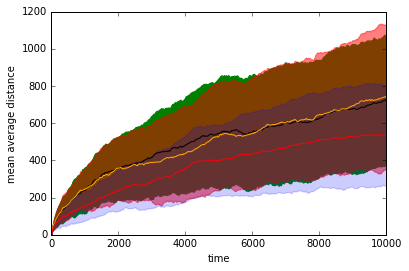

In [63]:
# the three lines all together
u=average_distances.mean(axis=0)
error=average_distances.var(axis=0)**0.5
y_new_data=average_new_data_distances.mean(axis=0)
error_new_data=average_new_data_distances.var(axis=0)**0.5
y_change=average_distances_change.mean(axis=0)
error_change=average_distances_change.var(axis=0)**0.5
plt.plot(t_new,y_new_data,color='black')
plt.fill_between(t_new, y_new_data-error_new_data, y_new_data+error_new_data,color='green',alpha=1)
plt.plot(t,u,color='orange')
plt.fill_between(t, u-error, u+error,color='red',alpha=0.5)
plt.plot(t_new[:-2],average_distances_change.mean(axis=0),color='red')
plt.fill_between(t_new[:-2], y_change-error_change, y_change+error_change,color='blue',alpha=0.2)
plt.xlabel('time')
plt.ylabel('mean average distance')
plt.show()

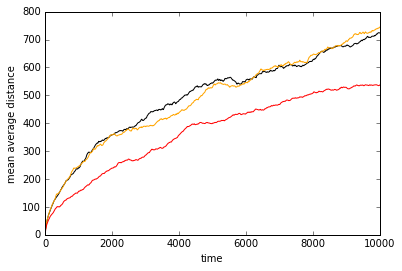

In [64]:
# the three lines all together without shaded areas
u=average_distances.mean(axis=0)
error=average_distances.var(axis=0)**0.5
y_new_data=average_new_data_distances.mean(axis=0)
error_new_data=average_new_data_distances.var(axis=0)**0.5
y_change=average_distances_change.mean(axis=0)
error_change=average_distances_change.var(axis=0)**0.5
plt.plot(t_new,y_new_data,color='black')
#plt.fill_between(t_new, y_new_data-error_new_data, y_new_data+error_new_data,color='green',alpha=1)
plt.plot(t,u,color='orange')
#plt.fill_between(t, y-error, y+error,color='red',alpha=0.5)
plt.plot(t_new[:-2],average_distances_change.mean(axis=0),color='red')
#plt.fill_between(t_new[:-2], y_change-error_change, y_change+error_change,color='blue',alpha=0.2)
plt.xlabel('time')
plt.ylabel('mean average distance')
plt.show()

In [65]:
#time_step=0.3
# my code pretty much starts here
time_step=0.3
t_new=np.arange(0,n-1,time_step)
f=interpolate.interp1d(t,x,kind='cubic')#,fill_value="extrapolate")
g=interpolate.interp1d(t,y,kind='cubic')#,fill_value="extrapolate") don't do this

In [66]:
x_new=f(t_new)
y_new=g(t_new)

In [67]:
#get the distances now and the angles
r=np.zeros(len(x_new)-1)# r the step-lengths
theta=np.zeros(len(x_new)-1)# theta the angle
new_data=np.zeros(len(x_new)-1)
for i in range(0,len(x_new)-1):
    r[i]=np.sqrt((x_new[i+1]-x_new[i])**2 + (y_new[i+1]-y_new[i])**2)
    theta[i]=math.atan2(y_new[i+1]-y_new[i], x_new[i+1]-x_new[i])
for i in range(0,len(x_new)-2):
    new_data[i]=theta[i+1]-theta[i]# save the difference in the heading
    if new_data[i]<0:
        new_data[i]=new_data[i]+2*math.pi    
data=r# save the step-lengths,have the same name as before in the MCMC sampler for the step-lengths
#new_data is the data that we introduce in the heading MCMC sampler
print(len(data))    
print(len(theta))
print(len(new_data))
new_data# it has a zero at the end
new_data=new_data[:-1]
#new_data without zero.
data=data[:-1]# change the step-lengths data as well
print(len(data))
print(len(new_data))# make sure they have the same lenghts

33329
33329
33329
33328
33328


In [68]:
#MCMC sampler for the heading
# initial guess for theta(a) as array,these are shape(c) 
guess = 0.9
# Prepare storing MCMC chain as array of arrays.
A1 = [guess]
# define stepsize of MCMC.
stepsize = 0.001 # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_wclikelihood(new_data,old_theta,0)#calculate the first log likelihood
# Metropolis-Hastings with 20,000 iterations.
for p in range(20000):
    new_theta = old_theta + stats.norm(0, stepsize).rvs() 
    #add the restraints on new_theta
    if new_theta<0 or new_theta>1: 
        continue
    new_loglik = log_wclikelihood(new_data,new_theta,0)
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A1.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A1.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
        else:
            A1.append(old_theta)
print("Acceptance rate = "+str(accepted/10000.0))

Acceptance rate = 0.4351


In [69]:
#MCMC sampler for the step-lengths
import scipy.stats as stats
import numpy as np
# initial guess for theta(a and b) as array.
guess = [5.0,2.0]
# Prepare storing MCMC chain as array of arrays.
A2 = [guess]
# define stepsize of MCMC.
stepsizes = [0.0065,0.0065]  # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_likelihood(data,old_theta[0],old_theta[1])#calculate the first log likelihood
# Metropolis-Hastings with 20,000 iterations.
for p in range(20000):
    # Suggest new candidate from Gaussian proposal distribution.
    new_theta = old_theta + stats.norm(0, stepsizes).rvs() 
    #add the restraints on new_theta
    if new_theta[0]<0 or new_theta[1]<0: 
        continue
    new_loglik = log_likelihood(data,new_theta[0],new_theta[1])
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A2.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A2.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
        else:
            A2.append(old_theta)
print("Acceptance rate = "+str(accepted/10000.0))

Acceptance rate = 0.418


20001
1.86844000987
0.398889620081


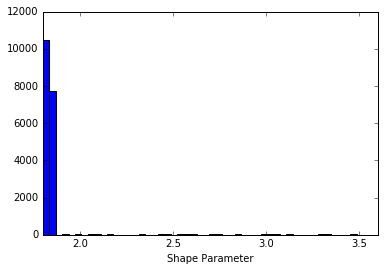

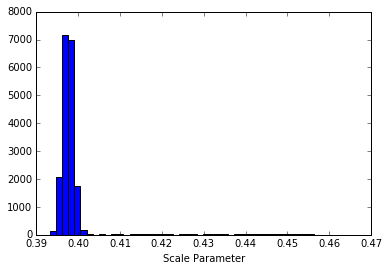

In [70]:
print(len(A2))
B2=np.array(A2[1000:])#burn-in 1000
shape_mean=np.mean(B2[:,0])
scale_mean=np.mean(B2[:,1])
print(shape_mean)
print(scale_mean)
plt.hist(B2[:,0],bins=50)
plt.xlabel("Shape Parameter")
plt.show()
plt.hist(B2[:,1],bins=50)
plt.xlabel("Scale Parameter")
plt.show()

In [71]:
# now changing the parameters and n with the ones that I got
def rw2_change(n_change):# this gives samples from weibull(5,2)
    x_change=np.zeros(n_change)
    y_change=np.zeros(n_change)
    theta=[0]*n_change
    distance=[0]*n_change
    theta[0]=wrapcauchy.rvs(c_change,loc=0,size=1)
    if theta[0]>2*math.pi:
            theta[0] = theta[0] - 2* math.pi
    if theta[0]<0:
            theta[0] = theta[0] + 2* math.pi
    for i in range(1,n_change):
        r=random.weibullvariate(alpha_change,beta_change)
        theta[i]=wrapcauchy.rvs(c_change,loc=theta[i-1],size=1)# c is the shape parameter
        if theta[i]>2*math.pi:
            theta[i] =theta[i] - 2* math.pi
        if theta[i]<0:
            theta[i] = theta[i] + 2* math.pi
        x_change[i]=x_change[i-1]+r*math.cos(theta[i])
        y_change[i]=y_change[i-1]+r*math.sin(theta[i])
        distance[i]=(x_change[i]**2+y_change[i]**2)**0.5
    return distance 
    
n_change=len(new_data) #int(input("how many steps?"))
alpha_change=scale_mean #int(input("what's the scale?"))
beta_change=shape_mean #int(input("what's the shape?"))
c_change=np.mean(A1)# float(input("What's the shape parameter for the wrapped Cauchy?"))# this needs to be between 0 and 1


In [72]:
number_of_simulations=100
average_distances_change=np.zeros((number_of_simulations,n_change))
for i in range(number_of_simulations):
    average_distances_change[i]=rw2_change(n_change)

In [73]:
print(len(t_new))
print(len(average_distances_change.mean(axis=0)))

33330
33328


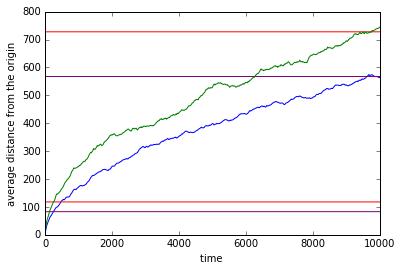

In [74]:
#plt.plot(t_new[:-2],average_distances_change.mean(axis=0))
#plt.plot(t,average_distances.mean(axis=0))
#plt.xlabel('time')
#plt.ylabel('average distance from the origin')
lower_end_vector_original=[np.percentile(average_distances.mean(axis=0),2.5)]*len(t)
upper_end_vector_original=[np.percentile(average_distances.mean(axis=0),97.5)]*len(t)
lower_end_vector_change=[np.percentile(average_distances_change.mean(axis=0),2.5)]*len(t_new[:-2])
upper_end_vector_change=[np.percentile(average_distances_change.mean(axis=0),97.5)]*len(t_new[:-2])
ninetyfive_percentile_original=[np.percentile(average_distances.mean(axis=0),95)]*len(t)
ninetyfive_percentile_change=[np.percentile(average_distances_change.mean(axis=0),95)]*len(t_new[:-2])
plt.plot(t_new[:-2],average_distances_change.mean(axis=0))#important
plt.plot(t,lower_end_vector_original,color='red')
plt.plot(t,upper_end_vector_original,color='red')
plt.plot(t_new[:-2],lower_end_vector_change,color='purple')
plt.plot(t_new[:-2],upper_end_vector_change,color='purple')
#plt.plot(t_new[:-2],ninetyfive_percentile_change,color='orange')
#plt.plot(t,ninetyfive_percentile_original,color='orange')
plt.ylabel('average distance from the origin')
plt.xlabel('time ')
plt.plot(t,average_distances.mean(axis=0))#important


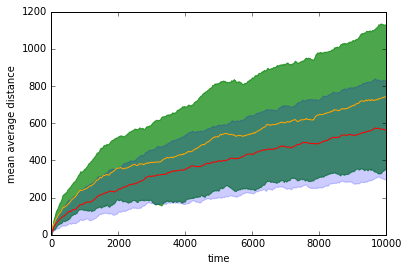

In [75]:
u=average_distances.mean(axis=0)
error=average_distances.var(axis=0)**0.5
y_change=average_distances_change.mean(axis=0)
error_change=average_distances_change.var(axis=0)**0.5
plt.plot(t,u,color='orange')
plt.fill_between(t, u-error, u+error,color='green',alpha=0.7)
plt.plot(t_new[:-2],average_distances_change.mean(axis=0),color='red')
plt.fill_between(t_new[:-2], y_change-error_change, y_change+error_change,color='blue',alpha=0.2)
#plt.plot(t,y-error)
#plt.plot(t,y+error)
plt.xlabel('time')
plt.ylabel('mean average distance')
plt.show()
# the portion in the middle is the intersection of the two shaded areas
# the boundaries are: for the green one : the upper line together with the last line of the intersection line
# for the blue one: the lowest line is the lower boundary and the upper line of the intersection 
#is the upper boundary

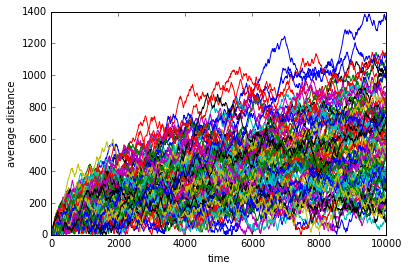

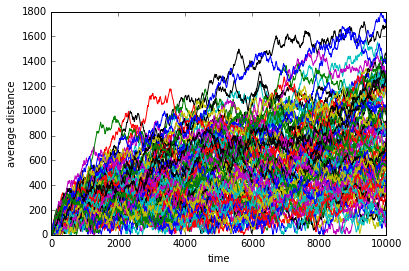

In [77]:
plt.plot(t_new[:-2],average_distances_change.T)
plt.ylabel('average distance')
plt.xlabel('time')
plt.show()
plt.plot(t,average_distances.T)
plt.ylabel('average distance')
plt.xlabel('time')
plt.show()

In [78]:
# calculating the distance from the origin in the new data
# this is just for one sample
distance_origin_new_data=np.zeros(len(x_new))
distance_origin_new_data=(x_new**2+y_new**2)**0.5

In [79]:
distance_origin_new_data

array([  0.0000e+00,   7.4440e-01,   1.5774e+00, ...,   1.1512e+03,
         1.1509e+03,   1.1505e+03])

In [80]:
#I need to do the mean average distance across the number of simulations

In [81]:
number_new_simulations=100
average_new_data_distances=np.zeros((number_new_simulations,len(x_new)))

In [82]:
for i in range(number_new_simulations):
                               data=rw2(n)
                               x=data[0]
                               y=data[1]
                               t_new=np.arange(0,n-1,time_step)
                               f=interpolate.interp1d(t,x,kind='cubic')
                               g=interpolate.interp1d(t,y,kind='cubic')
                               x_new=f(t_new)
                               y_new=g(t_new)
                               distance_origin_new_data=np.zeros(len(x_new))
                               distance_origin_new_data=(x_new**2+y_new**2)**0.5# this becomes the first row and so on of the matrix
                               average_new_data_distances[i,]=distance_origin_new_data

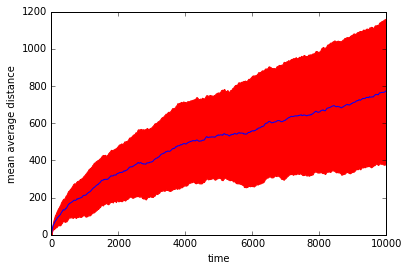

In [83]:
# the mean average distance after 1 step, 2 steps, etc...
y_new_data=average_new_data_distances.mean(axis=0)
error_new_data=average_new_data_distances.var(axis=0)**0.5
plt.plot(t_new,y_new_data)
plt.fill_between(t_new, y_new_data-error_new_data, y_new_data+error_new_data,color='red')
plt.xlabel('time')
plt.ylabel('mean average distance')
plt.show()
#ninety_fifth_percentile=np.percentile(y_new_data,95)
#fifth_percentile=np.percentile(y_new_data,5)
#plt.plot(t,y)
#plt.fill_between(t,ninety_fifth_percentile,alpha=0.5,color='red')
#plt.fill_between(t,fifth_percentile,ninety_fifth_percentile,color='red',alpha=0.5)
#plt.show()

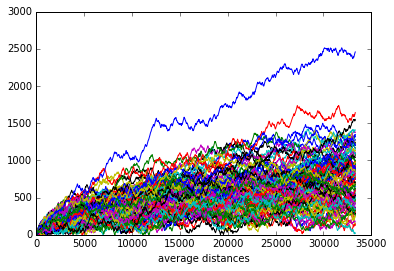

In [84]:
plt.plot(average_new_data_distances.T)
plt.xlabel('time')
plt.xlabel('average distances')
plt.show()

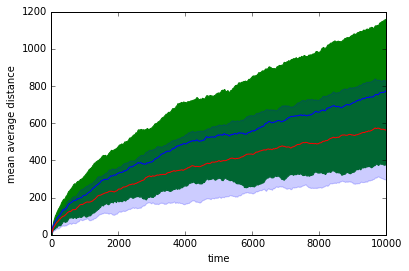

In [86]:
# the line from the inference and the line from the new data
y_new_data=average_new_data_distances.mean(axis=0)
error_new_data=average_new_data_distances.var(axis=0)**0.5
plt.plot(t_new,y_new_data)
plt.fill_between(t_new, y_new_data-error_new_data, y_new_data+error_new_data,color='green')
y_change=average_distances_change.mean(axis=0)
error_change=average_distances_change.var(axis=0)**0.5
plt.plot(t_new[:-2],average_distances_change.mean(axis=0),color='red')
plt.fill_between(t_new[:-2], y_change-error_change, y_change+error_change,color='blue',alpha=0.2)
plt.xlabel('time')
plt.ylabel('mean average distance')
plt.show()
# the portion in the middle is the intersection of the two shaded areas
# the boundaries are: for the green one : the upper line together with the last line of the intersection line
# for the blue one: the lowest line is the lower boundary and the upper line of the intersection 
#is the upper boundary
#the most important box

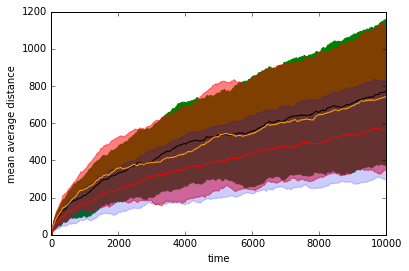

In [87]:
# the three lines all together
u=average_distances.mean(axis=0)
error=average_distances.var(axis=0)**0.5
y_new_data=average_new_data_distances.mean(axis=0)
error_new_data=average_new_data_distances.var(axis=0)**0.5
y_change=average_distances_change.mean(axis=0)
error_change=average_distances_change.var(axis=0)**0.5
plt.plot(t_new,y_new_data,color='black')
plt.fill_between(t_new, y_new_data-error_new_data, y_new_data+error_new_data,color='green',alpha=1)
plt.plot(t,u,color='orange')
plt.fill_between(t, u-error, u+error,color='red',alpha=0.5)
plt.plot(t_new[:-2],average_distances_change.mean(axis=0),color='red')
plt.fill_between(t_new[:-2], y_change-error_change, y_change+error_change,color='blue',alpha=0.2)
plt.xlabel('time')
plt.ylabel('mean average distance')
plt.show()


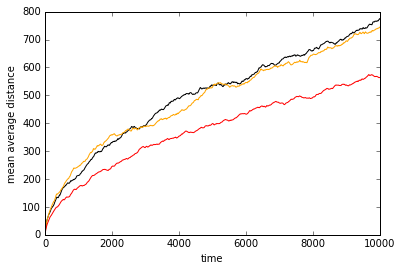

In [88]:
# the three lines all together without shaded areas
u=average_distances.mean(axis=0)
error=average_distances.var(axis=0)**0.5
y_new_data=average_new_data_distances.mean(axis=0)
error_new_data=average_new_data_distances.var(axis=0)**0.5
y_change=average_distances_change.mean(axis=0)
error_change=average_distances_change.var(axis=0)**0.5
plt.plot(t_new,y_new_data,color='black')
#plt.fill_between(t_new, y_new_data-error_new_data, y_new_data+error_new_data,color='green',alpha=1)
plt.plot(t,u,color='orange')
#plt.fill_between(t, y-error, y+error,color='red',alpha=0.5)
plt.plot(t_new[:-2],average_distances_change.mean(axis=0),color='red')
#plt.fill_between(t_new[:-2], y_change-error_change, y_change+error_change,color='blue',alpha=0.2)
plt.xlabel('time')
plt.ylabel('mean average distance')
plt.show()

In [89]:
#time_step=2
# my code pretty much starts here
time_step=2
t_new=np.arange(0,n-1,time_step)
f=interpolate.interp1d(t,x,kind='cubic')#,fill_value="extrapolate")
g=interpolate.interp1d(t,y,kind='cubic')#,fill_value="extrapolate") don't do this

In [90]:
x_new=f(t_new)
y_new=g(t_new)

In [91]:
#get the distances now and the angles
r=np.zeros(len(x_new)-1)# r the step-lengths
theta=np.zeros(len(x_new)-1)# theta the angle
new_data=np.zeros(len(x_new)-1)
for i in range(0,len(x_new)-1):
    r[i]=np.sqrt((x_new[i+1]-x_new[i])**2 + (y_new[i+1]-y_new[i])**2)
    theta[i]=math.atan2(y_new[i+1]-y_new[i], x_new[i+1]-x_new[i])
for i in range(0,len(x_new)-2):
    new_data[i]=theta[i+1]-theta[i]# save the difference in the heading
    if new_data[i]<0:
        new_data[i]=new_data[i]+2*math.pi    
data=r# save the step-lengths,have the same name as before in the MCMC sampler for the step-lengths
#new_data is the data that we introduce in the heading MCMC sampler
print(len(data))    
print(len(theta))
print(len(new_data))
new_data# it has a zero at the end
new_data=new_data[:-1]
#new_data without zero.
data=data[:-1]# change the step-lengths data as well
print(len(data))
print(len(new_data))# make sure they have the same lenghts

4999
4999
4999
4998
4998


In [92]:
#MCMC sampler for the heading
# initial guess for theta(a) as array,these are shape(c) 
guess = 0.9
# Prepare storing MCMC chain as array of arrays.
A1 = [guess]
# define stepsize of MCMC.
stepsize = 0.01 # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_wclikelihood(new_data,old_theta,0)#calculate the first log likelihood
# Metropolis-Hastings with 20,000 iterations.
for p in range(20000):
    new_theta = old_theta + stats.norm(0, stepsize).rvs() 
    #add the restraints on new_theta
    if new_theta<0 or new_theta>1: 
        continue
    new_loglik = log_wclikelihood(new_data,new_theta,0)
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A1.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A1.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
        else:
            A1.append(old_theta)
print("Acceptance rate = "+str(accepted/10000.0))

Acceptance rate = 0.35


In [93]:
#MCMC sampler for the step-lengths
import scipy.stats as stats
import numpy as np
# initial guess for theta(a and b) as array.
guess = [5.0,2.0]
# Prepare storing MCMC chain as array of arrays.
A2 = [guess]
# define stepsize of MCMC.
stepsizes = [0.06,0.06]  # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_likelihood(data,old_theta[0],old_theta[1])#calculate the first log likelihood
# Metropolis-Hastings with 20,000 iterations.
for p in range(20000):
    # Suggest new candidate from Gaussian proposal distribution.
    new_theta = old_theta + stats.norm(0, stepsizes).rvs() 
    #add the restraints on new_theta
    if new_theta[0]<0 or new_theta[1]<0: 
        continue
    new_loglik = log_likelihood(data,new_theta[0],new_theta[1])
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A2.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A2.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
        else:
            A2.append(old_theta)
print("Acceptance rate = "+str(accepted/10000.0))

Acceptance rate = 0.3523


20001
1.97013477827
2.5829487476


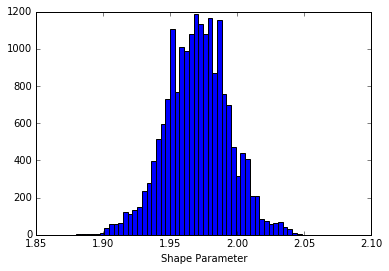

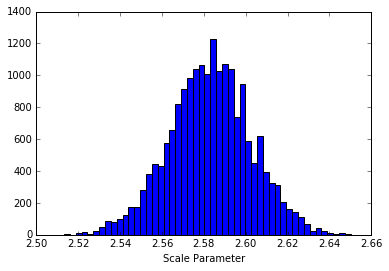

In [94]:
print(len(A2))
B2=np.array(A2[1000:])#burn-in 1000
shape_mean=np.mean(B2[:,0])
scale_mean=np.mean(B2[:,1])
print(shape_mean)
print(scale_mean)
plt.hist(B2[:,0],bins=50)
plt.xlabel("Shape Parameter")
plt.show()
plt.hist(B2[:,1],bins=50)
plt.xlabel("Scale Parameter")
plt.show()

In [95]:
# now changing the parameters and n with the ones that I got
def rw2_change(n_change):# this gives samples from weibull(5,2)
    x_change=np.zeros(n_change)
    y_change=np.zeros(n_change)
    theta=[0]*n_change
    distance=[0]*n_change
    theta[0]=wrapcauchy.rvs(c_change,loc=0,size=1)
    if theta[0]>2*math.pi:
            theta[0] = theta[0] - 2* math.pi
    if theta[0]<0:
            theta[0] = theta[0] + 2* math.pi
    for i in range(1,n_change):
        r=random.weibullvariate(alpha_change,beta_change)
        theta[i]=wrapcauchy.rvs(c_change,loc=theta[i-1],size=1)# c is the shape parameter
        if theta[i]>2*math.pi:
            theta[i] =theta[i] - 2* math.pi
        if theta[i]<0:
            theta[i] = theta[i] + 2* math.pi
        x_change[i]=x_change[i-1]+r*math.cos(theta[i])
        y_change[i]=y_change[i-1]+r*math.sin(theta[i])
        distance[i]=(x_change[i]**2+y_change[i]**2)**0.5
    return distance 
    
n_change=len(new_data) #int(input("how many steps?"))
alpha_change=scale_mean #int(input("what's the scale?"))
beta_change=shape_mean #int(input("what's the shape?"))
c_change=np.mean(A1)# float(input("What's the shape parameter for the wrapped Cauchy?"))# this needs to be between 0 and 1


In [96]:
number_of_simulations=100
average_distances_change=np.zeros((number_of_simulations,n_change))
for i in range(number_of_simulations):
    average_distances_change[i]=rw2_change(n_change)

In [97]:
print(len(t_new))
print(len(average_distances_change.mean(axis=0)))

5000
4998


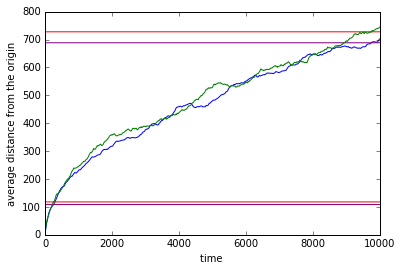

In [98]:
#plt.plot(t_new[:-2],average_distances_change.mean(axis=0))
#plt.plot(t,average_distances.mean(axis=0))
#plt.ylabel('average distance from the origin')
#plt.xlabel('time')
lower_end_vector_original=[np.percentile(average_distances.mean(axis=0),2.5)]*len(t)
upper_end_vector_original=[np.percentile(average_distances.mean(axis=0),97.5)]*len(t)
lower_end_vector_change=[np.percentile(average_distances_change.mean(axis=0),2.5)]*len(t_new[:-2])
upper_end_vector_change=[np.percentile(average_distances_change.mean(axis=0),97.5)]*len(t_new[:-2])
ninetyfive_percentile_original=[np.percentile(average_distances.mean(axis=0),95)]*len(t)
ninetyfive_percentile_change=[np.percentile(average_distances_change.mean(axis=0),95)]*len(t_new[:-2])
plt.plot(t_new[:-2],average_distances_change.mean(axis=0))#important
plt.plot(t,lower_end_vector_original,color='red')
plt.plot(t,upper_end_vector_original,color='red')
plt.plot(t_new[:-2],lower_end_vector_change,color='purple')
plt.plot(t_new[:-2],upper_end_vector_change,color='purple')
#plt.plot(t_new[:-2],ninetyfive_percentile_change,color='orange')
#plt.plot(t,ninetyfive_percentile_original,color='orange')
plt.ylabel('average distance from the origin')
plt.xlabel('time ')
plt.plot(t,average_distances.mean(axis=0))#important


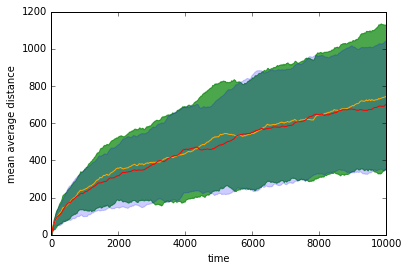

In [99]:
u=average_distances.mean(axis=0)
error=average_distances.var(axis=0)**0.5
y_change=average_distances_change.mean(axis=0)
error_change=average_distances_change.var(axis=0)**0.5
plt.plot(t,u,color='orange')
plt.fill_between(t, u-error, u+error,color='green',alpha=0.7)
plt.plot(t_new[:-2],average_distances_change.mean(axis=0),color='red')
plt.fill_between(t_new[:-2], y_change-error_change, y_change+error_change,color='blue',alpha=0.2)
#plt.plot(t,y-error)
#plt.plot(t,y+error)
plt.xlabel('time')
plt.ylabel('mean average distance')
plt.show()
# the portion in the middle is the intersection of the two shaded areas
# the boundaries are: for the green one : the upper line together with the last line of the intersection line
# for the blue one: the lowest line is the lower boundary and the upper line of the intersection 
#is the upper boundary

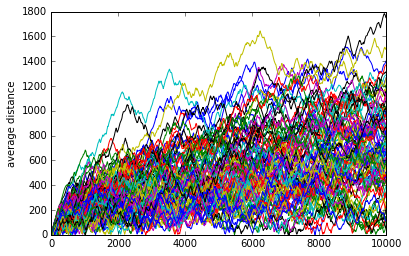

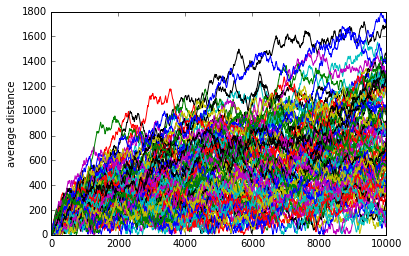

In [101]:
plt.plot(t_new[:-2],average_distances_change.T)
plt.ylabel('average distance')
plt.show()
plt.plot(t,average_distances.T)
plt.ylabel('average distance')
plt.show()

In [102]:
# calculating the distance from the origin in the new data
# this is just for one sample
distance_origin_new_data=np.zeros(len(x_new))
distance_origin_new_data=(x_new**2+y_new**2)**0.5

In [103]:
distance_origin_new_data

array([   0.    ,    4.1454,    8.2174, ...,  991.0227,  989.8347,
        988.5243])

In [104]:
#I need to do the mean average distance across the number of simulations

In [105]:
number_new_simulations=100
average_new_data_distances=np.zeros((number_new_simulations,len(x_new)))

In [106]:
for i in range(number_new_simulations):
                               data=rw2(n)
                               x=data[0]
                               y=data[1]
                               t_new=np.arange(0,n-1,time_step)
                               f=interpolate.interp1d(t,x,kind='cubic')
                               g=interpolate.interp1d(t,y,kind='cubic')
                               x_new=f(t_new)
                               y_new=g(t_new)
                               distance_origin_new_data=np.zeros(len(x_new))
                               distance_origin_new_data=(x_new**2+y_new**2)**0.5# this becomes the first row and so on of the matrix
                               average_new_data_distances[i,]=distance_origin_new_data

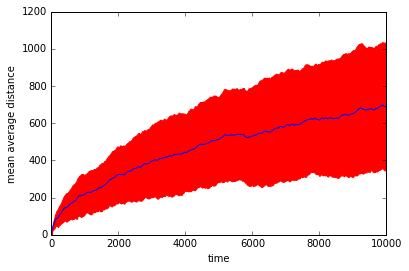

In [107]:
# the mean average distance after 1 step, 2 steps, etc...
y_new_data=average_new_data_distances.mean(axis=0)
error_new_data=average_new_data_distances.var(axis=0)**0.5
plt.plot(t_new,y_new_data)
plt.fill_between(t_new, y_new_data-error_new_data, y_new_data+error_new_data,color='red')
plt.xlabel('time')
plt.ylabel('mean average distance')
plt.show()
#ninety_fifth_percentile=np.percentile(y_new_data,95)
#fifth_percentile=np.percentile(y_new_data,5)
#plt.plot(t,y)
#plt.fill_between(t,ninety_fifth_percentile,alpha=0.5,color='red')
#plt.fill_between(t,fifth_percentile,ninety_fifth_percentile,color='red',alpha=0.5)
#plt.show()

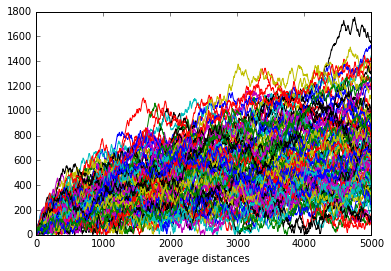

In [108]:
plt.plot(average_new_data_distances.T)
plt.xlabel('time')
plt.xlabel('average distances')
plt.show()

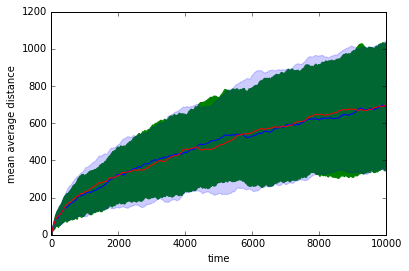

In [110]:
# the line from the inference and the line from the new data
y_new_data=average_new_data_distances.mean(axis=0)
error_new_data=average_new_data_distances.var(axis=0)**0.5
plt.plot(t_new,y_new_data)
plt.fill_between(t_new, y_new_data-error_new_data, y_new_data+error_new_data,color='green')
y_change=average_distances_change.mean(axis=0)
error_change=average_distances_change.var(axis=0)**0.5
plt.plot(t_new[:-2],average_distances_change.mean(axis=0),color='red')
plt.fill_between(t_new[:-2], y_change-error_change, y_change+error_change,color='blue',alpha=0.2)
plt.xlabel('time')
plt.ylabel('mean average distance')
plt.show()
# the portion in the middle is the intersection of the two shaded areas
# the boundaries are: for the green one : the upper line together with the last line of the intersection line
# for the blue one: the lowest line is the lower boundary and the upper line of the intersection 
#is the upper boundary
#the most important box

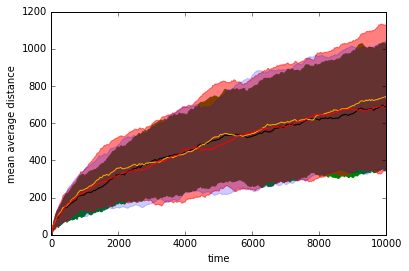

In [111]:
# the three lines all together
u=average_distances.mean(axis=0)
error=average_distances.var(axis=0)**0.5
y_new_data=average_new_data_distances.mean(axis=0)
error_new_data=average_new_data_distances.var(axis=0)**0.5
y_change=average_distances_change.mean(axis=0)
error_change=average_distances_change.var(axis=0)**0.5
plt.plot(t_new,y_new_data,color='black')
plt.fill_between(t_new, y_new_data-error_new_data, y_new_data+error_new_data,color='green',alpha=1)
plt.plot(t,u,color='orange')
plt.fill_between(t, u-error, u+error,color='red',alpha=0.5)
plt.plot(t_new[:-2],average_distances_change.mean(axis=0),color='red')
plt.fill_between(t_new[:-2], y_change-error_change, y_change+error_change,color='blue',alpha=0.2)
plt.xlabel('time')
plt.ylabel('mean average distance')
plt.show()

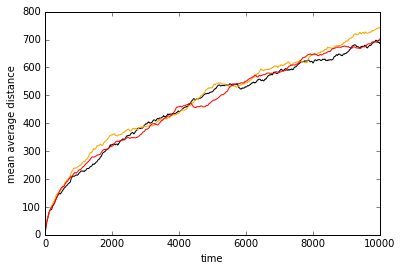

In [112]:
# the three lines all together without shaded areas
u=average_distances.mean(axis=0)
error=average_distances.var(axis=0)**0.5
y_new_data=average_new_data_distances.mean(axis=0)
error_new_data=average_new_data_distances.var(axis=0)**0.5
y_change=average_distances_change.mean(axis=0)
error_change=average_distances_change.var(axis=0)**0.5
plt.plot(t_new,y_new_data,color='black')
#plt.fill_between(t_new, y_new_data-error_new_data, y_new_data+error_new_data,color='green',alpha=1)
plt.plot(t,u,color='orange')
#plt.fill_between(t, y-error, y+error,color='red',alpha=0.5)
plt.plot(t_new[:-2],average_distances_change.mean(axis=0),color='red')
#plt.fill_between(t_new[:-2], y_change-error_change, y_change+error_change,color='blue',alpha=0.2)
plt.xlabel('time')
plt.ylabel('mean average distance')
plt.show()